---
title: World Population and Economic Growth
subtitle: Or, when did the singularity got cancelled?
---

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from IPython.display import display, Math, Latex

import plotly.graph_objects as go
import plotly.express as px

This post is based on and inspired by:
* [1960: The Year The Singularity Was Cancelled (Slate Star Codex, 2019)](https://slatestarcodex.com/2019/04/22/1960-the-year-the-singularity-was-cancelled/)
* Kremer, Michael. “Population Growth and Technological Change: One Million BC to 1990.” The Quarterly Journal of Economics 108, no. 3 (1993): 681–716.
* Paul Romer's work on endogeneous growth theory.
* etc

## World population, 10000 BC -- 2000 AD

Let's first import the world population. I got the dataset from [Our World in Data](https://ourworldindata.org/population-growth), and plot them.

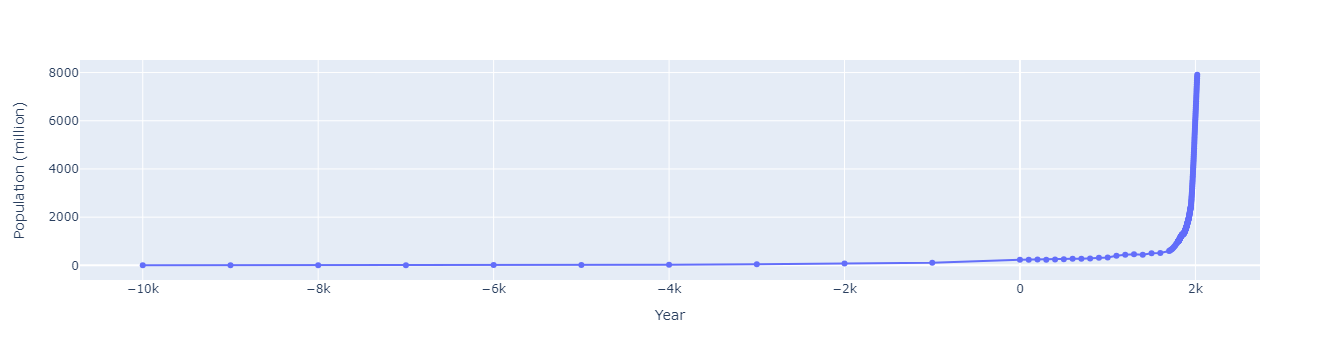

In [70]:
import plotly.express as px

fig = px.scatter(x=years_full, y=populations_full, labels={'x': 'Year', 'y': 'Population (million)'})
fig.update_traces(mode='lines+markers')

fig.update_layout(xaxis=dict(showgrid=True), yaxis=dict(showgrid=True))

# Show the plot
fig.show()

As usual, it looks way too much like a hockey stick. Let's plot it on log-scale.

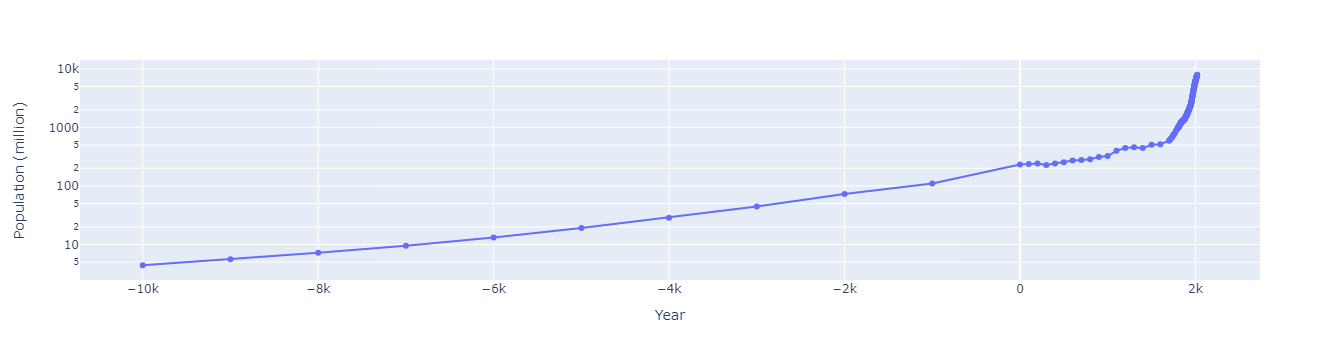

In [72]:
fig.update_layout(yaxis_type='log')

In [102]:
def make_sparkline(xs, ys):
    fig, ax = plt.subplots(1, 1, figsize=(10,2))
    ax.plot(xs, ys, linewidth=15)
    plt.axis('off')
    plt.tight_layout();
    plt.close();
    return fig

population_figure = make_sparkline(years_full, populations_full)
population_semilogy_figure = make_sparkline(years_full, np.log(populations_full))

The population graph {eval}`population_figure` is showing that characteristic hockey-stick shape again. Is it exponential? The semilog plot {eval}`population_semilogy_figure` looks closer to what we expected, moving up roughly linearly, but then it still turns sharply upwards.

In [108]:
df = pd.read_csv('world_population.csv')

filtered_df = df[(df['Entity'] == 'World')]
years_full = filtered_df['Year']
populations_full = filtered_df['Population (historical estimates)']/(10**6)

In [109]:
def growth_rate(year, population):
    logpop = np.log(np.array(population))
    year = np.array(year)
    loggrowth = (logpop[1:] - logpop[:-1]) / (year[1:] - year[:-1])
    return (year[:-1] + year[1:])/2, 100 * (np.exp(loggrowth) - 1)

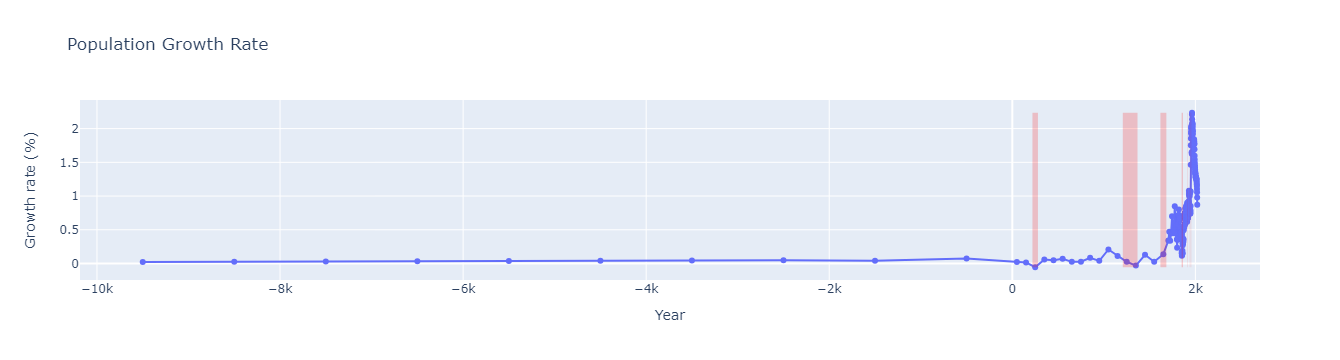

In [110]:
fig = go.Figure()

# Add a scatter trace with lines+markers
population_growth_years, population_growth_rates = growth_rate(years_full, populations_full)
fig.add_trace(go.Scatter(x=population_growth_years, y=population_growth_rates, mode='lines+markers', name='Growth Rate (%)'))

events = [
    (220, 280, "Three Kingdoms"), 
    (1207, 1368, "Black Death, Mongols"),
    (1618, 1683, "Ming to Qing"),
    (1850, 1864, "Taping Rebellion"),
    (1914, 1918, "WWI"),
    (1939, 1945, "WWII"),
    (1959, 1961, "Great Leap Forward")]
for year0, year1, event in events:
    fig.add_shape(
        type='rect',
        x0=year0, x1=year1, 
        y0=min(population_growth_rates), y1=max(population_growth_rates),
        fillcolor='rgba(255, 0, 0, 0.2)',
        line=dict(color='rgba(255, 0, 0, 0)'),
        name=event
    )
    fig.add_trace(go.Scatter(x=[(year0 + year1)/2], y=[max(ys) / 2], mode='text', 
                             marker=dict(size=0), showlegend=False, hovertext=event))

# Update the layout
fig.update_layout(
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    title='Population Growth Rate',
    hovermode='x'
)

fig.update_xaxes(title_text='Year')
fig.update_yaxes(title_text='Growth rate (%)')
fig.update_layout(showlegend=False)

fig.show()

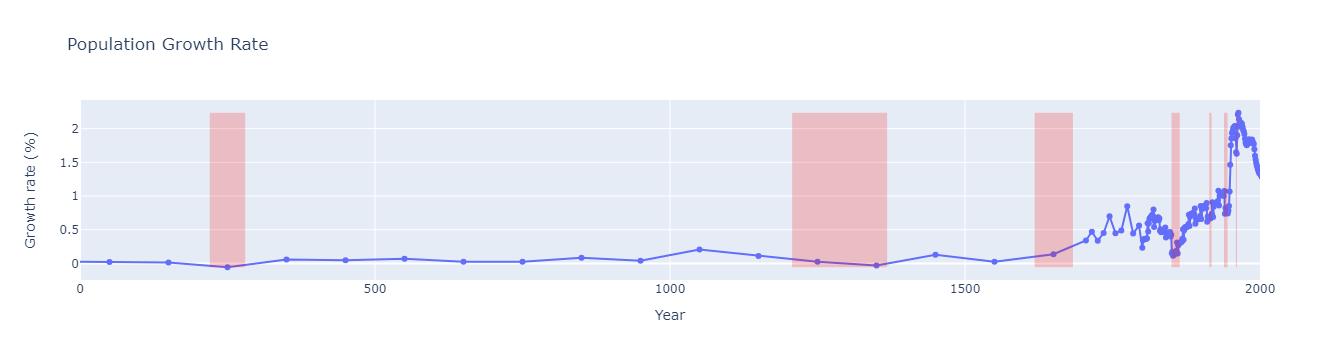

In [111]:
fig.update_xaxes(range=[0, 2000])

In [103]:
def power_law(t, C, a, t_infty):
    return C / ((t_infty - t) ** a)

filtered_df = df[(df['Entity'] == 'World') & (df['Year'] >= -10000) & (df['Year'] <= 1900)]
years = filtered_df['Year']
populations = filtered_df['Population (historical estimates)']/(10**6)

popt, _ = curve_fit(power_law, years, populations, p0=[10000, 1, 2000])
C_fit, a_fit, t_infty_fit = popt

params_latex = fr'$\frac{{{C_fit:.0f}}}{{({t_infty_fit:.0f} - t)^{{{a_fit:.2f}}}}}$'
display(Math(params_latex))

<IPython.core.display.Math object>

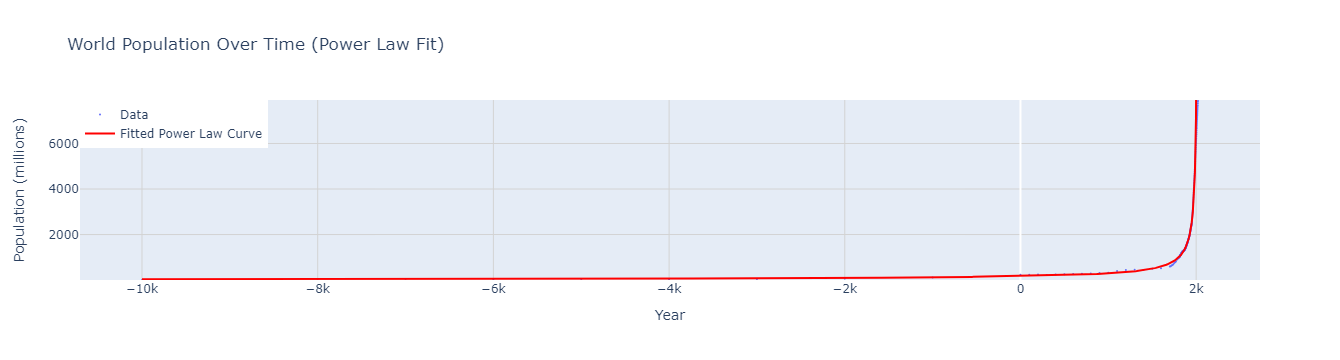

In [23]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=years_full, y=populations_full, mode='markers', name='Data', marker=dict(size=2)))

t_values = np.linspace(min(years_full), 2010, 1000)
p_values = power_law(t_values, C_fit, a_fit, t_infty_fit)
fig.add_trace(go.Scatter(x=t_values, y=p_values, mode='lines', name='Fitted Power Law Curve', line=dict(color='red')))

fig.update_xaxes(title_text='Year')
fig.update_yaxes(title_text='Population (millions)')
fig.update_layout(title_text='World Population Over Time (Power Law Fit)')

fig.update_layout(legend=dict(x=0, y=1))

# fig.add_annotation(text=params_latex, x=0.15, y=0.2, showarrow=False, font=dict(size=12), bgcolor='white', opacity=0.5)
# The above line ruins things for some reason. LaTeX doesn't work with Plotly+Jupyter Book. Whatever.

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

fig.update_yaxes(range=[min(populations_full), max(populations_full)])

fig.show()

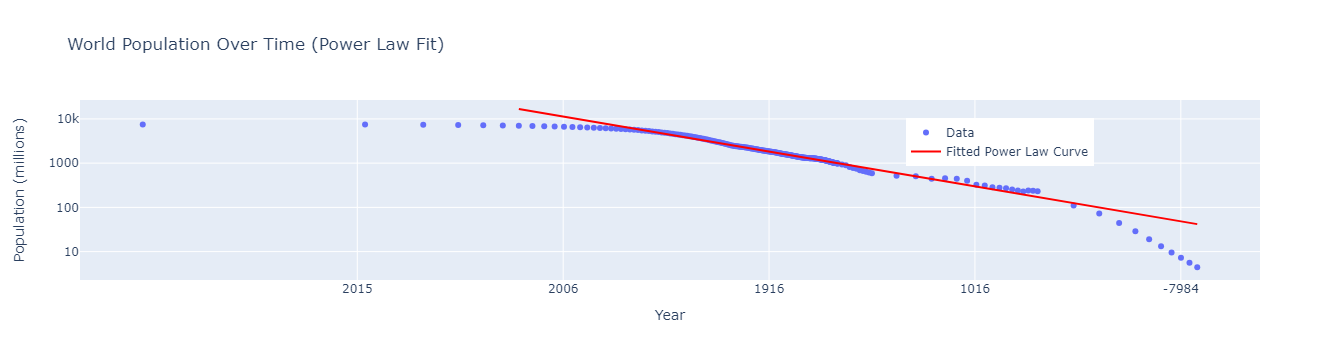

In [161]:
xticks_list = [-1, -10, -100, -1000, -10000]
fig = go.Figure()

t_infty = t_infty_fit
# Add a scatter trace with custom hover text
fig.add_trace(go.Scatter(
    x=t_infty - years_full,
    y=populations_full,
    mode='markers',
    name='Data',
    hoverinfo='text',  # Show only custom hover text
    text=[f'Year: {year}, Population: {pop:.0f}' for (year, pop) in zip(years_full, populations_full)]
))

# Add the fitted power law curve
fig.add_trace(go.Scatter(x=(t_infty - t_values), y=(p_values), mode='lines', name='Fitted Power Law Curve', line=dict(color='red')))

fig.update_xaxes(type='log', tickvals=[-t for t in xticks_list], ticktext=[f'{t_infty + t:.0f}' for t in xticks_list], title='Year')
fig.update_yaxes(type='log', title='Population (millions)')
fig.update_layout(title='World Population Over Time (Power Law Fit)', legend=dict(x=0.7, y=0.9), hovermode='closest')

fig.show()

## How to think about population like a physicist

The population history during the past 12000 years has three important regimes:
* During the years $\in [-10000, -1000]$, the population growth had a high power law growth.
* During the years $\in [-1000, 1980]$, the population had a lower power law growth.
* Sometime around 1970 -- 1990, the population growth has stopped following a power law.

The second regime, of low power-law growth can be well-fitted to a power law of form

$$p(t) = \frac{C}{(t_\infty - t)^a}$$

with $a \approx$ {eval}`f"{a_fit:.2f}"`, $t_\infty \approx$ {eval}`f"{t_infty_fit:.0f}"` (year), and $C \approx$ {eval}`f"{C_fit:.0f}"` (million). This then implies the population growth rate is 

$$\frac{\dot p}{p} = \frac{d}{dt} \ln p = \frac{a}{t_\infty - t} \propto p^{1/a}$$

The fact that $\frac{\dot p}{p} \propto p^{1/0.8}$ over a period of about 3000 years is something remarkable: Unlike in a Malthusian economy, where population growth rate is something like $\frac{\dot p}{p} \propto (p - p_{stable})$, the more the population grows, the faster it grows... until it doesn't.

Why did it grow faster and faster, and why did it stop?

Why did it grow faster and faster? This is the question that launched a thousand macroeconomics papers.

Why did it stop? Suuppose it kept growing like that, then the population would literally reach infinity at year {eval}`f"{t_infty_fit:.0f}"`. What are we supposed to make of that? The answer is pretty obvious, of course -- people simply cannot reproduce fast enough. The population growth rate hit an all-time high of {eval}`f"{max(population_growth_rates/100):.1%}"` in year {eval}`f"{population_growth_years[np.argmax(population_growth_rates)]:.0f}"`.

This then predicts that the model would break down when $\dot p/p \approx 0.02$, giving us the theoretical time when the model must break down:

$$t_\infty - \frac{a}{0.02}$$

which happens in year {eval}`f"{t_infty_fit - a_fit/.02:.0f}"`.

### Toy model of population growth

Consider a toy model of population, as follows. As usual we ignore all factors that change the answer by no more than 50%. The model is supposed to be a quick model for a relatively healthy population practicing some mild form of birth control. A good mental picture would be some land, around 1900, where people are fairly well-fed, and mostly die after their fertile age is over (after 50), interested in reproduction, but not totally devoted to it. This should give us a good guess to the *upper bound* of population growth rate without serious reproductive technologies like artificial uterus, greatly compressed pregnancy and infancy, or other similar methods.

* The population has exactly 1:1 sex ratio. That is, $1/2$ of the population are female. In reality, human population ratio deviates from this by up to 10%, especially when there is sex-selective abortion and infanticide.
* Each pregnancy lasts 9 months. Pregnancies rarely last longer than 10 months, and earlier than 7 months is dangerously early.
* Women become fertile around 20 years old, and stops around 35 years old.
    * As populations get richer, the fertility window shifts up -- women reproduce older, but also stop reproducing older. Poor populations tend to have a fertility window of $[15, 30]$ while richer populations shift upwards to about $[25, 40]$. See figures such as [^1].
    * Insert citation here.
* it takes about 3 years for the mother to be become pregnant again. Then she does become pregnant.
    * This is a more complex assumption. It is mainly based on some brief anthropology I read. They generally found that the grown children of one woman are usually spaced out by about 4 years. This could be explained by deliberate lactational amenorrhea. A mother performing occasional breastfeeding can suppress menstruation and thus pregnancy.
    * Why do populations use this method of biological birth control? A human, being born early and helpless, takes about 2--3 years to become independent enough to not be a serious burden on its parents, and the parents know this. Consequently they try to space out the births so that they are not overwhelmed by parental work.
    * Rich women can hire others to do their childrearing. If they mainly hire other fertile women, then this does not actually allow faster population growth, since while the rich women are free to have children faster, those hired women have children slower. Similar comments apply for surrogacy.
    * Population growth can get faster if infertile humans (usually meaning men and old women) take up significant work. In this case, the inter-birth interval 
* Each successful birth produces one offspring. That is, we assume no twins, triples, etc. In reality, twin births account for about 3% of live births (triplets etc are so much rarer), which would change our number by about 7%.
* The population has life expectancy of 60 years. Real populations have different kinds of life expectancies, of course, usually from 45--70.
    * Some even go so far as to claim 25 years of life expectancy. However if we remove the massive infant mortality, the life expectancy usually improves to somewhere like 50.
    * In populations expecting high infant mortality, prospective mothers actually try to become pregnant quickly, before the previous child has become old enough, so that after "giving nature its due", the surviving children are spaced 4 years apart on average. This then gets us back to the toy model again.

### Predictions of the toy model

Let's check the basic predictions of the model.

* Total fertility rate: How many children does a woman have over lifetime?
    * During a woman's life, the births are separated by about $4$ years, and the window of fertility is about $15$ years, giving us $15/4 = 3.75$ children.
    * This corresponds well with the typical number of about 3--4 during periods of population expansion, such as 1950s Europe.
* Population birth rate: How many newborns per person per year?
    * During any given year, about $1/2$ of the population is female, and of those, about $15/60$ are fertile, and of those, about $1/4$ are ready to become pregnant (the others are busy being pregnant, or raising a baby).
    * Thus, the birth rate is about $1/32 \approx \frac{30}{1000}$. This is close to the actual answer of 10--45 per thousand.
* Population growth rate: What is $p(t+1)/p(t)-1$, where $p(t)$ is the population of year $t$?
    * In a year, $1/32$ are born, and $1/60$ dies, giving us $1/32 - 1/60 \approx 1.5\%$. This is close to the actual historical maximum of {eval}`f"{max(population_growth_rates/100):.1%}"` in year {eval}`f"{population_growth_years[np.argmax(population_growth_rates)]:.0f}"`.


[^1]: De Iaco, Sandra, and Sabrina Maggio. "A dynamic model for age-specific fertility rates in Italy." Spatial Statistics 17 (2016): 105-120.

In [69]:
import ipywidgets as widgets

# Create sliders
lifeExpectancySlider = widgets.IntSlider(
    min=45, max=90, step=1, value=60
)
startOfFertilitySlider = widgets.IntSlider(
    min=14, max=22, step=1, value=20
)
endOfFertilitySlider = widgets.IntSlider(
    min=35, max=45, step=1, value=20
)
endOfInfancySlider = widgets.IntSlider(
    min=12, max=48, step=1, value=40
)

def maxReproductiveRate(lifeExpectancy, fertilityWindow, infancyLength):
    interbirthInterval = (9 + infancyLength)/12
    deathRate = 1/lifeExpectancy
    fertileWomenRatio = (fertilityWindow / lifeExpectancy) * (1 / interbirthInterval)
    return 0.5 * fertileWomenRatio - deathRate

# Create labels to display the slider values
lifeExpectancyLabel = widgets.Label(value=f'{lifeExpectancySlider.value}')
startOfFertilityLabel = widgets.Label(value=f'{startOfFertilitySlider.value}')
endOfFertilityLabel = widgets.Label(value=f'{endOfFertilitySlider.value}')
endOfInfancyLabel = widgets.Label(value=f'{endOfInfancySlider.value}')
maxReproductiveRateLabel = widgets.Label(value="")
endTimeLabel = widgets.Label(value="")

# Function to update labels when slider values change
def update_labels(change):
    lifeExpectancyLabel.value = f'{lifeExpectancySlider.value}'
    startOfFertilityLabel.value = f'{startOfFertilitySlider.value}'
    endOfFertilityLabel.value = f'{endOfFertilitySlider.value}'
    endOfInfancyLabel.value = f'{endOfInfancySlider.value}'
    r = maxReproductiveRate(lifeExpectancySlider.value, endOfFertilitySlider.value - startOfFertilitySlider.value, endOfInfancySlider.value)
    maxReproductiveRateLabel.value = f'{r:.1%}'
    endTimeLabel.value = f'{t_infty_fit - a_fit / r:.0f}'

# Observe slider changes and update labels
lifeExpectancySlider.observe(update_labels, 'value')
startOfFertilitySlider.observe(update_labels, 'value')
endOfFertilitySlider.observe(update_labels, 'value')
endOfInfancySlider.observe(update_labels, 'value')


:::{important} Customize Life Parameters 📅
- Life Expectancy: {eval}`lifeExpectancySlider` years
- Start of Fertility: {eval}`startOfFertilitySlider` years
- End of Fertility: {eval}`endOfFertilitySlider` years
- End of Infancy: {eval}`endOfInfancySlider` months
- Maximal reproductive rate: {eval}`maxReproductiveRateLabel`.
- Time at which power law growth of population must end: year {eval}`endTimeLabel`
:::


## How does the GDP grow?

The GDP isn't the best way to measure economic growth, but it's better than all alternatives. The GDP is, by definition, the population $\times$ GDP per capita, thus, it suffices to get the two datasets, one on GDP per capita, another on population.

Let import the GDP. I got the dataset from [Our World in Data](https://ourworldindata.org/grapher/world-gdp-over-the-last-two-millennia).

In [153]:
# df_gdp = pd.read_csv('gdppc_maddison.csv')
# years_gdppc = df_gdp[(df_gdp['Entity'] == 'World')]["Year"]
# gdppc = df_gdp[(df_gdp['Entity'] == 'World')]["GDP per capita"]
# years_gdppc_growth_rate, gdppc_growth_rate = growth_rate(years_gdppc, gdppc)
# plt.plot(years_gdppc, gdppc)
# plt.plot(years_gdppc_growth_rate, gdppc_growth_rate)

In [148]:
df_gdp = pd.read_csv('gdp.csv')
years_gdp = df_gdp[(df_gdp['Entity'] == 'World')]["Year"]
gdp = df_gdp[(df_gdp['Entity'] == 'World')]["World GDP in 2011 Int.$ (OWID based on World Bank & Maddison (2017))"]
years_gdp_growth_rate, gdp_growth_rate = growth_rate(years_gdp, gdp)

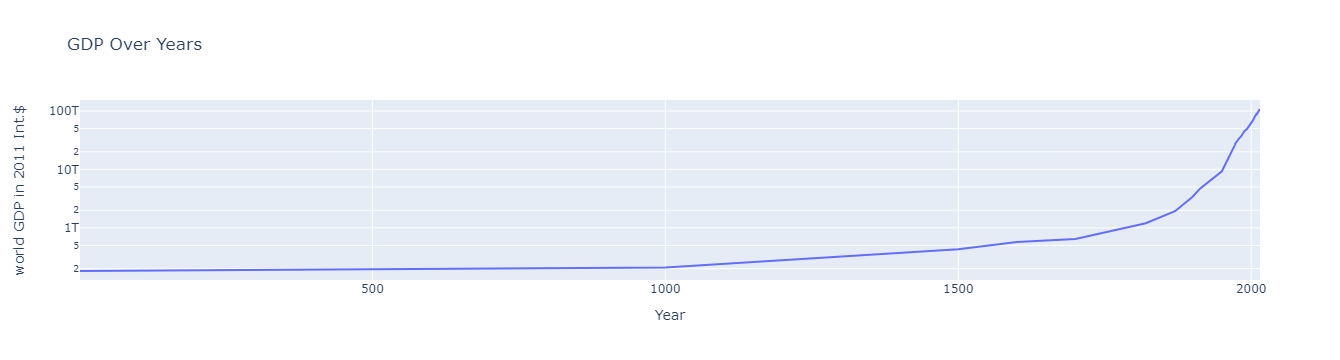

In [149]:
fig = go.Figure(data=go.Scatter(x=years_gdp, y=gdp, mode='lines'))

fig.update_layout(
    title='GDP Over Years',
    xaxis_title='Year',
    yaxis_title='world GDP in 2011 Int.$',
    showlegend=False
)
fig.update_yaxes(type='log')

fig.show()

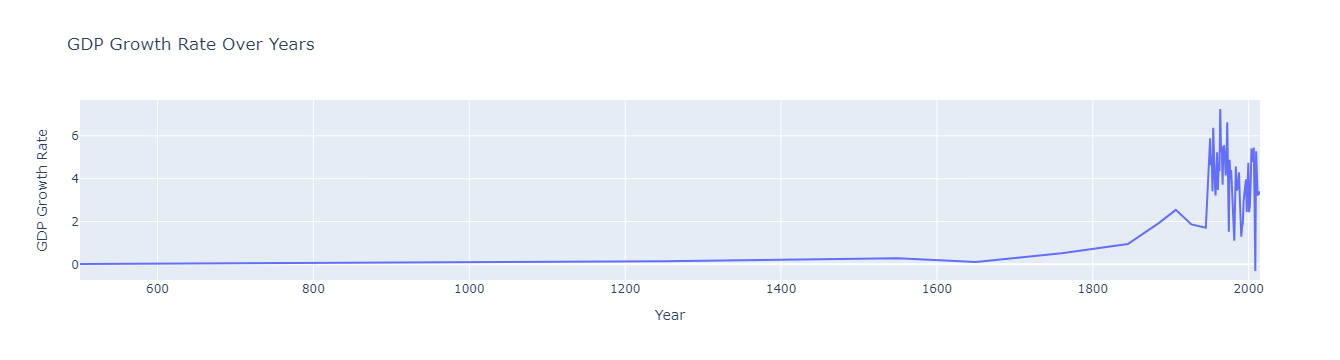

In [150]:
fig = go.Figure(data=go.Scatter(x=years_gdp_growth_rate, y=gdp_growth_rate, mode='lines'))

fig.update_layout(
    title='GDP Growth Rate Over Years',
    xaxis_title='Year',
    yaxis_title='GDP Growth Rate',
    showlegend=False
)

fig.show()

gdp_growth_rate_figure = make_sparkline(years_gdp_growth_rate, gdp_growth_rate)

If we squint a bit at the graph of GDP growth rate {eval}`gdp_growth_rate_figure`, we can see that it is also showing signs of superexponential growth, but hit a snag right around... 1970, almost right at the moment world population growth rate hit the maximum. After that, it has been years of *merely* exponential growth. Sure, exponential growth would be great, but why settle for exponential growth when you can go for powerlaw growth?

## How the singularity was cancelled

At this point, we can form a rough toy model for the history of human population and economic growth:
* As population grew, people created new innovations, allowing the same plot of land to carry more people.
* People reproduce to fill the land, which allows even more innovations, and so on.
* This leads us to a power-law growth.

This is the simplest model given in [^kremerPopulationGrowthTechnological1993].

Mathematically, the model states:

* GDP $Y$ is determined by technology $A$ , population $p$ , and land $T$, according to $Y = Ap^a T^{1-a}$
    * Since we don't deal with land expansion, we scale $A$ until $T=1$.
* Growth rate of technology is proportional to total population and technology: $\dot A = gp A$, where $g$ is a ratio constant.
    * The idea is that innovations are just as easy/hard to discover back then as it is now. One might try to model other possibilities, such as if innovations get harder to find, because the low-hanging fruits are gone.
* (Malthusian economy assumption): the population changes with GDP such that the GDP per capita always remains constant at $\bar y$.
    * This assumption is relaxed in the more complex models.

Plugging in the equations, one can easly find the solution: $\dot p/p = \frac{g}{1-a} p$, and $p(t) = \frac{C}{t_\infty - t}$ for some $C$.

[^kremerPopulationGrowthTechnological1993]: Kremer, Michael. “Population Growth and Technological Change: One Million BC to 1990.” The Quarterly Journal of Economics 108, no. 3 (1993): 681–716. https://doi.org/10.2307/2118405.
